In [2]:
using Pkg,Statistics,Random,Printf,Knet,Plots,LinearAlgebra,Distributions,StatsBase, SpecialFunctions, DelimitedFiles

## Generate training data

In [3]:
Random.seed!(1);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [4]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [5]:
# Generate a new training data set
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [17]:
#Uncomment to load training set used in paper
#x_train=readdlm("x_train.txt");
#y_train=readdlm("y_train.txt");

In [38]:
Ntrain =length(x_train) # number of training data points

200

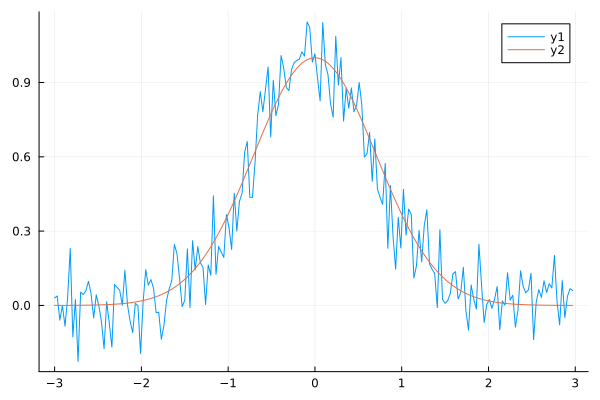

In [19]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [20]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical
σ = Noise_std

0.1

In [21]:
Nweights = 7
w = randn(Nweights)

7-element Vector{Float64}:
 -0.8849978358417646
 -0.4715797613859544
 -0.6237790750678033
 -0.4625189825889467
  0.16704447031801
  1.996085549214306
 -1.81800119502579

In [22]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [23]:
# both x and y are ordered in columns per training data point

# Mean squared error component of loss function
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))*Ntrain/(2*σ^2)
end

# Regularization component of loss function
function reg(w)
    return (Ntrain/(2*σ^2))*RegWeight*norm(w)^2
end

# Total loss function
function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [25]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
sqlossgradient = grad(sqloss);
reggradient = grad(reg);
lossgradient = grad(loss);

In [26]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
Random.seed!(2);
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [-0.005737244600260246, 1.7353762138709008, -1.0499249292429236, 0.5753709361353411, -0.36738997477480556, 1.0071663760294896, -1.2757079018632909]


7-element Vector{Float64}:
  -4218.943309007426
   3108.7313724110572
   3369.3041119064433
  -6785.04117086698
  18277.056182501383
  12407.674754519434
 -23497.22983199982

## Training function (with replacement)

In [14]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [27]:
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 200000; # For a quick training run
η = 1e-7; # Learning rate

In [28]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

34.46734404563904

## Diffusion, Hessian, Covariance Matrices

In [29]:
function diffusionmatrix(w,xt,yt,Nb,lr)
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [30]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [31]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [32]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::AutoGrad.var"#gradfun#6"{AutoGrad.var"#gradfun#5#7"{typeof(lossgradj), Int64, Bool}}) (generic function with 1 method)

In [33]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [34]:
# Calculate the theoretically predicted covariance matrix from the Lyapunov relation (Eq. 21)
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [40]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:20
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1];

In [41]:
# Uncomment to load previously calculated minimum
#wmin=readdlm("wmin.txt")

7×1 Matrix{Float64}:
  1.2833313725790076
  1.2307473940611995
  0.7045806188690756
 -0.5317508554411805
  0.92781446509604
 -0.9088462496180023
 -0.008841779321639548

In [42]:
# Check to see if gradient is zero at the minimum
lossgradient(wmin,x_train,y_train)

7×1 Matrix{Float64}:
  7.105427357601002e-15
 -1.0658141036401503e-14
 -1.7053025658242404e-13
  1.6342482922482304e-13
 -1.8829382497642655e-13
  1.1368683772161603e-13
 -1.5462631175466868e-13

### Hessian at the loss minimum

In [43]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Matrix{Float64}:
  1564.82    -434.384  -1705.16     …   1819.16      2916.94     -2618.86
  -434.384   1255.06     127.801       -2681.73     -1938.41     -2099.4
 -1705.16     127.801   3079.43           -7.17973  -3294.7       4810.69
   127.801   1331.01   -1676.18        -3365.27        -3.56877  -4912.82
  1819.16   -2681.73      -7.17973     14835.0      12254.6       3555.84
  2916.94   -1938.41   -3294.7      …  12254.6      14614.4      -2975.88
 -2618.86   -2099.4     4810.69         3555.84     -2975.88     20020.0

In [44]:
eigvals(Hessmin), norm(Hessmin)

([55.02366427863232, 58.51554270757967, 397.2543687273366, 1848.5641004652236, 3097.666373263998, 24658.45687004527, 28317.70872412742], 37724.118432321644)

### Diffusion tensor at the loss minimum

In [45]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Matrix{Float64}:
  1.72743e-10  -5.03373e-11  -1.90879e-10  …   3.21645e-10  -2.88537e-10
 -5.03373e-11   1.35119e-10   1.24197e-11     -2.02322e-10  -2.23702e-10
 -1.90879e-10   1.24197e-11   3.13806e-10     -3.49195e-10   5.00337e-10
  1.30115e-11   1.48156e-10  -1.61664e-10     -1.60646e-11  -5.06353e-10
  1.99773e-10  -2.87375e-10  -2.33141e-11      1.07445e-9    2.37448e-10
  3.21645e-10  -2.02322e-10  -3.49195e-10  …   1.3014e-9    -4.24224e-10
 -2.88537e-10  -2.23702e-10   5.00337e-10     -4.24224e-10   1.85885e-9

In [46]:
# compare with D calculated numerically (ratio of elements of both matrices)
Dmin_num = diffusionmatrix_num(wmin,200000,η);
Dmin_num ./ Dmin

7×7 Matrix{Float64}:
 1.00201   0.994289  0.999487  1.00854   1.00002   0.999346  0.996855
 0.994289  1.00204   1.03021   0.997688  0.997213  0.999749  1.00314
 0.999487  1.03021   1.00083   1.00215   1.03485   1.00413   0.997358
 1.00854   0.997688  1.00215   1.00092   0.995031  0.853517  1.00186
 1.00002   0.997213  1.03485   0.995031  0.996624  0.997521  1.00221
 0.999346  0.999749  1.00413   0.853517  0.997521  1.00035   0.998335
 0.996855  1.00314   0.997358  1.00186   1.00221   0.998335  0.999164

In [47]:
@show isapprox(Dmin_num,Dmin, rtol=0.05)

isapprox(Dmin_num, Dmin, rtol = 0.05) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [48]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Matrix{Float64}:
  7.7408e-7   -6.05204e-9  -2.32103e-7  …  -3.50794e-8  -2.93708e-8
 -6.05204e-9   7.53025e-7   3.1365e-8      -1.22938e-7  -5.55732e-8
 -2.32103e-7   3.1365e-8    6.88296e-7     -1.89337e-7   2.92516e-8
 -5.1893e-8    1.55486e-7   8.62246e-8      1.88516e-7  -6.187e-8
  8.23315e-8   6.05824e-8   1.78956e-7      2.36217e-7  -2.72374e-8
 -3.50794e-8  -1.22938e-7  -1.89337e-7  …   6.23246e-7  -8.45867e-8
 -2.93708e-8  -5.55732e-8   2.92516e-8     -8.45867e-8   8.88879e-7

In [49]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

1.1767074244839722e-16

## Steady state

In [50]:
η=1e-7;
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η);
Covmin = covariancematrix(Dmin,Hessmin,η);

In [51]:
# Directory for output files
dir="./";

In [52]:
Random.seed!(1)
Nmarkov = 3*10^7; # number of Markov steps

In [53]:
w = copy(wmin); # start from the minimum of the potential

In [54]:
# If the trajectory file exists, the code will load it instead of rerunning the trajectory.
fname = dir*"Gaussian_wr_ss-$Nmarkov-$η.jld2";
isfile(fname)

true

In [55]:
fname = dir*"Gaussian_wr_ss-$Nmarkov-$η.jld2"
if !isfile(fname)
    w_ss = zeros(Nweights,Nmarkov)
    time0 = time() # takes about an hour for Nmarkov = 10^7
    for n in progress(1:Nmarkov)
        w_ss[:,n] = batchtrain!(w,η)
    end
    @show time()-time0
    Knet.save(fname, "w_ss", w_ss)
else
    w_ss = Knet.load(fname, "w_ss");
end
@show summary(w_ss)

summary(w_ss) = "7×30000000 Matrix{Float64}"


"7×30000000 Matrix{Float64}"

### Fit a multivariable Gaussian to the stationary distribution

In [56]:
Fit_ss = fit_mle(MvNormal,w_ss);

### Steady-state mean


In [57]:
meanw = Distributions.mean(Fit_ss);

In [58]:
# Check to see the relative difference between numeric mean and theoretical prediction for loss minimum
norm(meanw-wmin)/norm(wmin)

5.224932402088824e-5

### Covariance matrix (from ss-trajectory)

In [59]:
Cov_ss = Distributions.cov(Fit_ss);

## Stochastic area matrix (circulation)

In [53]:
# Numerically calculate stochastic area matrix from the trajectory

function arealvelocity(traj,x,y,center)
    N = length(traj[1,:]) # trajectory length
    Area=zeros(N-1);
    Areasum=0
    for n=1:N-1
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        v2=[traj[x,n+1]-center[x],traj[y,n+1]-center[y],0]
        Areasum += cross(v1,v2)[3] # this is twice the area of the triangle
    end
    return Areasum/(2*(N-1))
end

fname = dir*"data/Gaussian_wr_arealvelocity_$Nmarkov.jld2"
if !isfile(fname)
    Av = zeros(Nweights,Nweights)
    time0 = time() # takes about 11 minutes for Nmarkov = 10^7
    for i in progress(1:Nweights-1)
        for j = i+1:Nweights # av is antisymmetric
            Av[i,j] = arealvelocity(w_ss,i,j,meanw)
            Av[j,i] = -Av[i,j]
        end
    end
    #Av /= η^2
    @show time()-time0
    
    Knet.save(fname, "Av", Av)
else
    Av = Knet.load(fname, "Av");
end

┣████████████████████┫ [100.00%, 6/6, 00:44/00:44, 7.27s/i] /s] 


time() - time0 = 43.647603034973145


In [54]:
# Numerically calculated area matrix
Av

7×7 Matrix{Float64}:
  0.0          3.7463e-8    6.80453e-8  …  -4.01849e-7   2.09829e-7
 -3.7463e-8    0.0          4.72313e-8      4.48637e-7   4.79025e-7
 -6.80453e-8  -4.72313e-8   0.0             1.7113e-7   -2.50299e-7
  5.04414e-8   4.65573e-9  -3.33202e-9      5.14848e-7   4.94965e-7
  2.89421e-7  -4.80836e-7  -1.22929e-7     -2.85001e-7  -3.85546e-7
  4.01849e-7  -4.48637e-7  -1.7113e-7   …   0.0         -4.44331e-8
 -2.09829e-7  -4.79025e-7   2.50299e-7      4.44331e-8   0.0

In [55]:
# Theoretically predicted area matrix
Av_theo=(η/2)*(Hessmin*Covmin - Covmin*Hessmin)

7×7 Matrix{Float64}:
  0.0          3.03345e-8   6.5987e-8    …  -4.0179e-7    1.81625e-7
 -3.03345e-8   0.0          4.44127e-8       4.46885e-7   4.7232e-7
 -6.5987e-8   -4.44127e-8   2.77556e-22      1.74996e-7  -2.11604e-7
  5.81334e-8   1.34349e-8  -6.02519e-9       5.05989e-7   4.72246e-7
  2.90052e-7  -4.85564e-7  -1.29732e-7      -2.70548e-7  -3.50809e-7
  4.0179e-7   -4.46885e-7  -1.74996e-7   …   0.0         -4.703e-8
 -1.81625e-7  -4.7232e-7    2.11604e-7       4.703e-8     0.0

## Fluctuation Theorems

In [60]:
# Circulation matrix C
C = (η/2)*(Hessmin*Covmin-Covmin*Hessmin)

7×7 Matrix{Float64}:
 -1.0842e-26    3.03345e-12   6.5987e-12   …  -4.0179e-11    1.81625e-11
 -3.03345e-12   0.0           4.44127e-12      4.46885e-11   4.7232e-11
 -6.5987e-12   -4.44127e-12   4.33681e-26      1.74996e-11  -2.11604e-11
  5.81334e-12   1.34349e-12  -6.02519e-13      5.05989e-11   4.72246e-11
  2.90052e-11  -4.85564e-11  -1.29732e-11     -2.70548e-11  -3.50809e-11
  4.0179e-11   -4.46885e-11  -1.74996e-11  …   0.0          -4.703e-12
 -1.81625e-11  -4.7232e-11    2.11604e-11      4.703e-12     0.0

In [61]:
# -C * covariance matrix (useful to calculate the velocity field)
m1 = -C*inv(Covmin);

In [62]:
# inverse of the diffusion matrix (useful to calculate entropy production)
m2 = inv(Dmin);

In [63]:
# subtracting the mean from the trajectory
dth = w_ss .- meanw;

In [64]:
# single time step displacements
dw = w_ss[:,2:end] - w_ss[:,1:end-1];

In [65]:
# epN is the entropy production for single time step trajectories (subsampled every 150 steps), starting with time N
ep=diag((m1*dth[:,1:150:end])'*m2*dw[:,1:150:end]);
ep2=diag((m1*dth[:,2:150:end])'*m2*dw[:,2:150:end]);
ep3=diag((m1*dth[:,3:150:end])'*m2*dw[:,3:150:end]);

In [69]:
# checking the integral fluctuation theorem for trajectories of length 1 (should be approx. equal to 1)
mean(exp.(-ep))

0.999973802421733

In [71]:
# checking the integral fluctuation theorem for trajectories of length 2 (should be approx. equal to 1)
mean(exp.(-ep-ep2))

0.9999384575061235

In [73]:
# checking the integral fluctuation theorem for trajectories of length 3 (should be approx. equal to 1)
mean(exp.(-ep-ep2-ep3))

0.9999316491960109

In [74]:
# checking the prediction of Eq. 29 for the mean entropy production of single time step trajectories
right_hand_side = -tr(C*inv(Dmin)*C*inv(Covmin))

0.00031482847448289646

In [75]:
left_hand_side = mean(ep)

0.0003444239819867815

In [78]:
# Construct histogram of exp(-σ) for single time step trajectories
histrange=0.8:0.004:1.2
efith = fit(Histogram,exp.(-ep),histrange)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  0.8:0.004:1.2
weights: [0, 1, 1, 0, 1, 2, 9, 3, 5, 4  …  4, 9, 10, 3, 2, 4, 2, 1, 5, 2]
closed: left
isdensity: false

In [79]:
# Construct histogram of σ for single time step trajectories
ehistrange=-0.15:0.01:0.15
epfith = fit(Histogram,ep,ehistrange)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.15:0.01:0.15
weights: [23, 49, 75, 119, 190, 273, 477, 782, 1315, 2273  …  2456, 1407, 845, 529, 307, 198, 120, 61, 59, 31]
closed: left
isdensity: false